In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [312]:
from sklearn.preprocessing import StandardScaler, PowerTransformer, FunctionTransformer, KBinsDiscretizer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, ShuffleSplit, StratifiedKFold 
from sklearn.model_selection import PredefinedSplit
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, HuberRegressor, Ridge, ElasticNet
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

In [248]:
def plot_residual(y_true, y_pred, title=''):
    
    res = y_pred - y_true

    plt.figure(figsize=(12, 6))

    plt.subplot(121)
    plt.plot(y_true, y_pred, '.')
    plt.plot([36, 46], [36, 46], 'k--')
    plt.xlabel('y_true')
    plt.ylabel('y_pred')

    plt.subplot(122)
    plt.plot(y_pred, res, '.')
    plt.axhline(color='k', linestyle='--')
    plt.xlabel('y_pred')
    plt.ylabel('residuals')
    
    plt.gcf().suptitle(title)

In [ ]:
# characteristics:
# ---------------
# Y:
# - somewhat normal distribution
# - regression problem
#
# X: [176 x 57]
# - few missing values in some columns -> impute[mean,median]
# - all numeric features 
# - different scale -> StandardScaler
# - some degenerative features -> 'BiologicalMaterial07'
# - some skew-distribution -> try powertransform
# - collinearity issue -> try pcr, pls

# preprocessing:
# -------------
# 

# metrics:
# -------
# - r2
# - rmse

# resamplings:
# -----------
# train/test split : final evaluation
# repeated k-folds : model tuning

# models:
# ------
# - Linear Regression
# - Ridge
# - ElasticNet
# - PLS
# - PCR

In [4]:
data = pd.read_csv('data/ChemicalManufacturingProcess/ChemicalManufacturingProcess.csv', 
                   index_col=0)

data.head()

,Yield,BiologicalMaterial01,BiologicalMaterial02,BiologicalMaterial03,BiologicalMaterial04,BiologicalMaterial05,BiologicalMaterial06,BiologicalMaterial07,BiologicalMaterial08,BiologicalMaterial09,...,ManufacturingProcess36,ManufacturingProcess37,ManufacturingProcess38,ManufacturingProcess39,ManufacturingProcess40,ManufacturingProcess41,ManufacturingProcess42,ManufacturingProcess43,ManufacturingProcess44,ManufacturingProcess45
1,38.00,6.25,49.58,56.97,12.74,19.51,43.73,100.0,16.66,11.44,...,0.019,0.5,3.0,7.2,NaN,NaN,11.6,3.0,1.8,2.4
2,42.44,8.01,60.97,67.48,14.65,19.36,53.14,100.0,19.04,12.55,...,0.019,2.0,2.0,7.2,0.1,0.15,11.1,0.9,1.9,2.2
3,42.03,8.01,60.97,67.48,14.65,19.36,53.14,100.0,19.04,12.55,...,0.018,0.7,2.0,7.2,0.0,0.00,12.0,1.0,1.8,2.3
4,41.42,8.01,60.97,67.48,14.65,19.36,53.14,100.0,19.04,12.55,...,0.018,1.2,2.0,7.2,0.0,0.00,10.6,1.1,1.8,2.1
5,42.49,7.47,63.33,72.25,14.02,17.91,54.66,100.0,18.22,12.80,...,0.017,0.2,2.0,7.3,0.0,0.00,11.0,1.1,1.7,2.1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176 entries, 1 to 176
Data columns (total 58 columns):
Yield                     176 non-null float64
BiologicalMaterial01      176 non-null float64
BiologicalMaterial02      176 non-null float64
BiologicalMaterial03      176 non-null float64
BiologicalMaterial04      176 non-null float64
BiologicalMaterial05      176 non-null float64
BiologicalMaterial06      176 non-null float64
BiologicalMaterial07      176 non-null float64
BiologicalMaterial08      176 non-null float64
BiologicalMaterial09      176 non-null float64
BiologicalMaterial10      176 non-null float64
BiologicalMaterial11      176 non-null float64
BiologicalMaterial12      176 non-null float64
ManufacturingProcess01    175 non-null float64
ManufacturingProcess02    173 non-null float64
ManufacturingProcess03    161 non-null float64
ManufacturingProcess04    175 non-null float64
ManufacturingProcess05    175 non-null float64
ManufacturingProcess06    174 non-null float64
Ma

In [7]:
data.dtypes.value_counts()

float64    58
dtype: int64

In [10]:
data.nunique().value_counts().head(10)

2      5
106    3
105    3
103    2
4      2
10     2
14     2
79     2
17     2
27     2
dtype: int64

In [11]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Yield,176.0,40.176534,1.845666,35.250,38.7525,39.970,41.4750,46.340
BiologicalMaterial01,176.0,6.411420,0.713923,4.580,5.9775,6.305,6.8700,8.810
BiologicalMaterial02,176.0,55.688750,4.034581,46.870,52.6800,55.090,58.7375,64.750
BiologicalMaterial03,176.0,67.705000,4.001064,56.970,64.9800,67.220,70.4275,78.250
BiologicalMaterial04,176.0,12.349261,1.774661,9.380,11.2450,12.100,13.2200,23.090
BiologicalMaterial05,176.0,18.598636,1.844141,13.240,17.2350,18.490,19.9000,24.850
BiologicalMaterial06,176.0,48.910398,3.746072,40.600,46.0550,48.460,51.3450,59.380
BiologicalMaterial07,176.0,100.014148,0.107742,100.000,100.0000,100.000,100.0000,100.830
BiologicalMaterial08,176.0,17.494773,0.676954,15.880,17.0600,17.510,17.8800,19.140
BiologicalMaterial09,176.0,12.850057,0.415176,11.440,12.6025,12.835,13.1300,14.080


In [14]:
cols = """ManufacturingProcess12
ManufacturingProcess34
ManufacturingProcess36
ManufacturingProcess40
ManufacturingProcess41""".split()
cols

['ManufacturingProcess12',
 'ManufacturingProcess34',
 'ManufacturingProcess36',
 'ManufacturingProcess40',
 'ManufacturingProcess41']

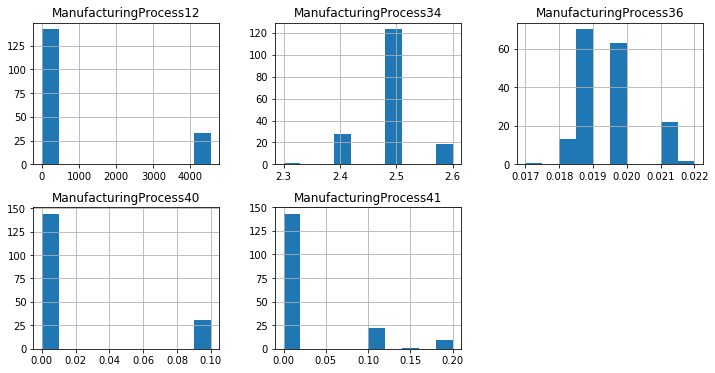

In [18]:
axs = data[cols].hist(figsize=(12, 6), layout=(2, 3))

In [23]:
manu_cols = data.columns[data.columns.str.startswith('Manufact')].tolist()
bio_cols = data.columns[data.columns.str.startswith('Bio')].tolist()


len(manu_cols), len(bio_cols)

(45, 12)

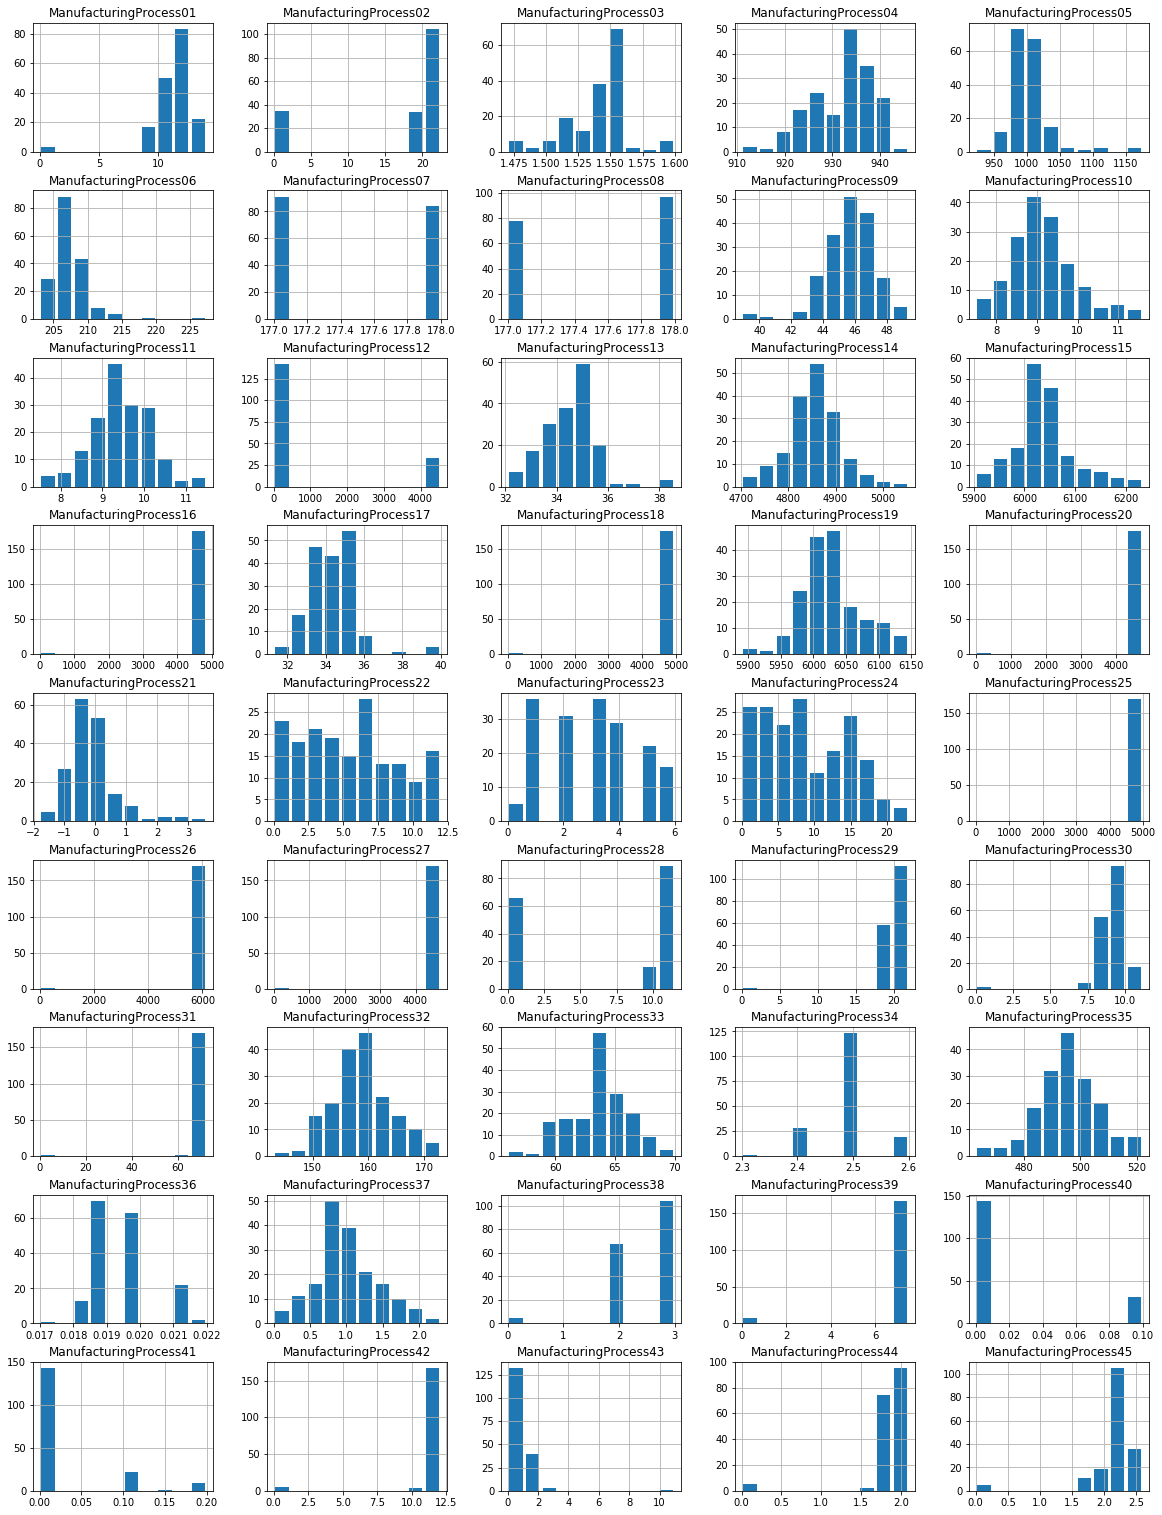

In [25]:
# manufacturing features
axs = data[manu_cols].hist(figsize=(20, 27), layout=(9, 5), rwidth=.8)

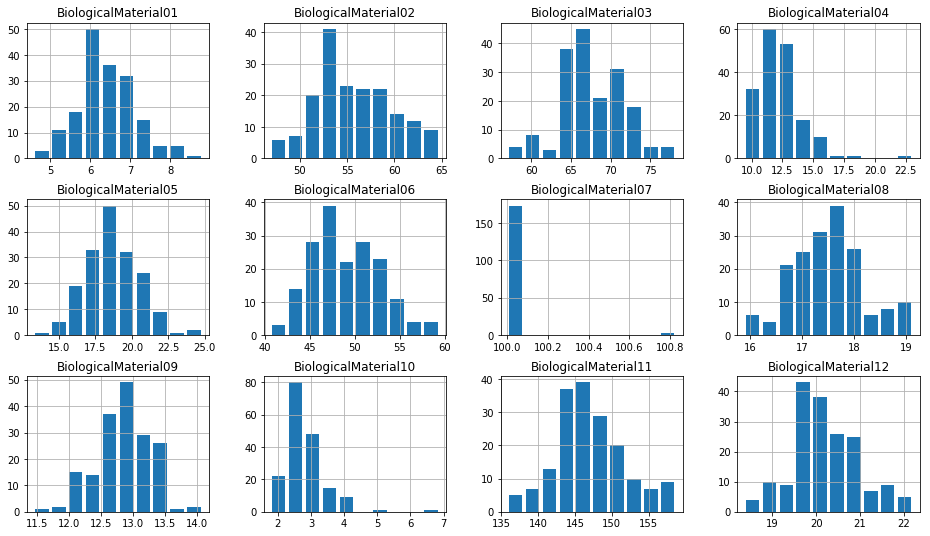

In [26]:
axs = data[bio_cols].hist(figsize=(16, 9), layout=(3, 4), rwidth=.8)

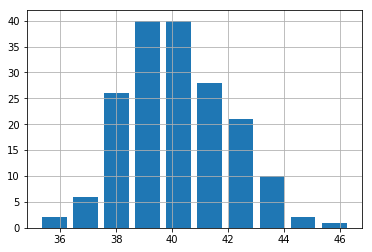

In [32]:
# target distribution: look normal

data.Yield.hist(rwidth=.8)

In [35]:
# find degenerative features
# - low unique values/sample size (< 10%)
# - high #top1/#top2 ratio (> 20)

pct_unique_by_cols = data.nunique() / len(data) * 100
pct_unique_by_cols.head()

Yield                   85.227273
BiologicalMaterial01    50.568182
BiologicalMaterial02    60.227273
BiologicalMaterial03    57.386364
BiologicalMaterial04    57.954545
dtype: float64

In [37]:
# potential degenerative features
degen_cols = pct_unique_by_cols.index[pct_unique_by_cols <= 10]
degen_cols

Index(['BiologicalMaterial07', 'ManufacturingProcess03',
       'ManufacturingProcess07', 'ManufacturingProcess08',
       'ManufacturingProcess12', 'ManufacturingProcess22',
       'ManufacturingProcess23', 'ManufacturingProcess28',
       'ManufacturingProcess33', 'ManufacturingProcess34',
       'ManufacturingProcess36', 'ManufacturingProcess38',
       'ManufacturingProcess39', 'ManufacturingProcess40',
       'ManufacturingProcess41', 'ManufacturingProcess42',
       'ManufacturingProcess44', 'ManufacturingProcess45'],
      dtype='object')

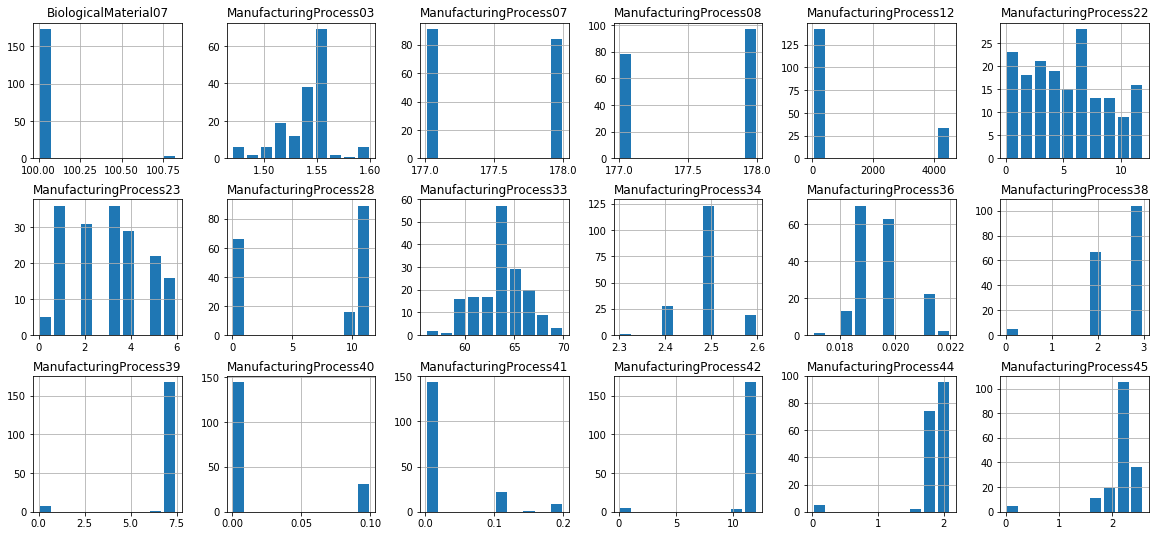

In [39]:
axs = data[degen_cols].hist(rwidth=.8, layout=(3,6), figsize=(20, 9))

In [55]:
def is_degen(x):
    # get first 2 values
    count1, count2 = pd.value_counts(x).head(2).values
    if count1/count2 >= 20:
        return True
    return False

In [56]:
is_degen_cols = data[degen_cols].apply(is_degen)
is_degen_cols

BiologicalMaterial07       True
ManufacturingProcess12    False
ManufacturingProcess28    False
ManufacturingProcess34    False
ManufacturingProcess40    False
ManufacturingProcess41    False
dtype: bool

In [57]:
degen_cols = is_degen_cols.index[is_degen_cols].tolist()
degen_cols

['BiologicalMaterial07']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023ACD779550>]],
      dtype=object)

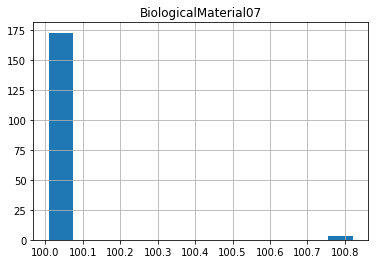

In [59]:
data[degen_cols].hist(rwidth=.8)

In [67]:
# correlation coeff
corr = data.corr()

In [69]:
target_corr = corr['Yield'].sort_values()

In [73]:
target_corr.head(10)

ManufacturingProcess36   -0.528420
ManufacturingProcess13   -0.503680
ManufacturingProcess17   -0.425807
ManufacturingProcess04   -0.263550
ManufacturingProcess24   -0.210200
ManufacturingProcess02   -0.206276
ManufacturingProcess35   -0.174233
ManufacturingProcess37   -0.159314
ManufacturingProcess01   -0.101343
ManufacturingProcess23   -0.096880
Name: Yield, dtype: float64

In [72]:
target_corr.tail(10)

BiologicalMaterial04      0.379840
BiologicalMaterial08      0.380940
ManufacturingProcess06    0.389013
ManufacturingProcess33    0.425621
BiologicalMaterial03      0.445086
BiologicalMaterial06      0.478163
BiologicalMaterial02      0.481516
ManufacturingProcess09    0.503471
ManufacturingProcess32    0.608332
Yield                     1.000000
Name: Yield, dtype: float64

In [76]:
# remove target feature
corr = data.drop(columns='Yield').corr()

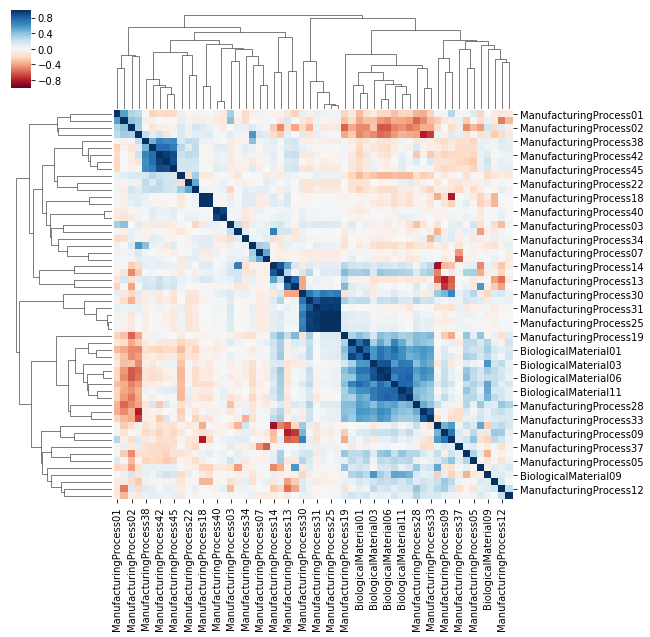

In [77]:
sns.clustermap(corr, figsize=(9,9), vmin=-1., vmax=1., cmap=plt.cm.RdBu)

In [88]:
# find highly correlated features
def find_correlated_columns(corr, threshold=.9):
    all_cols = corr.columns.tolist()
    candidate_pairs = sorted([(all_cols[i], all_cols[j], abs(corr.iloc[i,j]))
                               for i in range(len(all_cols)-1) 
                               for j in range(i+1, len(all_cols)) 
                               if abs(corr.iloc[i,j]) > threshold],
                             key=lambda x: x[-1], reverse=False)

    to_remove = set()
    for col1, col2, _ in candidate_pairs:
        if (col1 in to_remove) or (col2 in to_remove):
            continue
        if corr[col1].abs().mean() > corr[col2].abs().mean():
            to_remove.add(col1)
        else:
            to_remove.add(col2)

    to_remove = list(to_remove)
    print("Given threshold={:.2f}, found {} columns above the threshold".format(threshold, len(to_remove)))
    return to_remove

In [94]:
to_remove_by_threshold = {}
for threshold in np.arange(.6, .91, .05):
    to_remove = find_correlated_columns(corr, threshold)
    to_remove_by_threshold[round(threshold, 2)] = to_remove

Given threshold=0.60, found 25 columns above the threshold
Given threshold=0.65, found 23 columns above the threshold
Given threshold=0.70, found 21 columns above the threshold
Given threshold=0.75, found 18 columns above the threshold
Given threshold=0.80, found 17 columns above the threshold
Given threshold=0.85, found 14 columns above the threshold
Given threshold=0.90, found 10 columns above the threshold


In [96]:
to_remove_by_threshold.keys()

dict_keys([0.6, 0.65, 0.8, 0.7, 0.9, 0.85, 0.75])

In [409]:
# remove correlated cols above 90% 
data = data.drop(columns=to_remove_by_threshold[.9])

In [ ]:
# preprocessing
data = data.drop(columns='BiologicalMaterial07')

In [411]:
# spliting train/test
train, test = train_test_split(data, test_size=.25, random_state=42)
train.shape, test.shape

((132, 47), (44, 47))

In [430]:
# resampling method
k10 = KFold(n_splits=10, shuffle=True, random_state=123)
ss = ShuffleSplit(n_splits=25, test_size=.25, random_state=123)

g10 = StratifiedKFold(n_splits=5, random_state=123)

In [341]:
kbins = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform')
y_bins = kbins.fit_transform(y_train[:, None])

test_idx = np.empty_like(y_train, dtype=int)

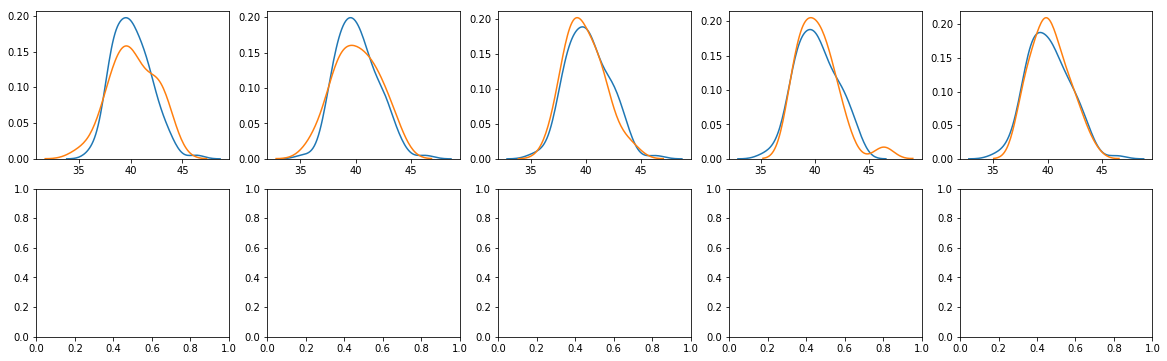

In [342]:
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(20, 6))

i = 0
for ax, (tr_idx, val_idx) in zip(axs.flat, g10.split(X_train, y_bins, groups=y_bins)):
    sns.kdeplot(y_train[tr_idx], ax=ax)
    sns.kdeplot(y_train[val_idx], ax=ax)
    
    test_idx[val_idx] = i
    i += 1

In [343]:
pd.value_counts(test_idx)

0    29
3    26
2    26
1    26
4    25
dtype: int64

In [344]:
pfs = PredefinedSplit(test_idx)

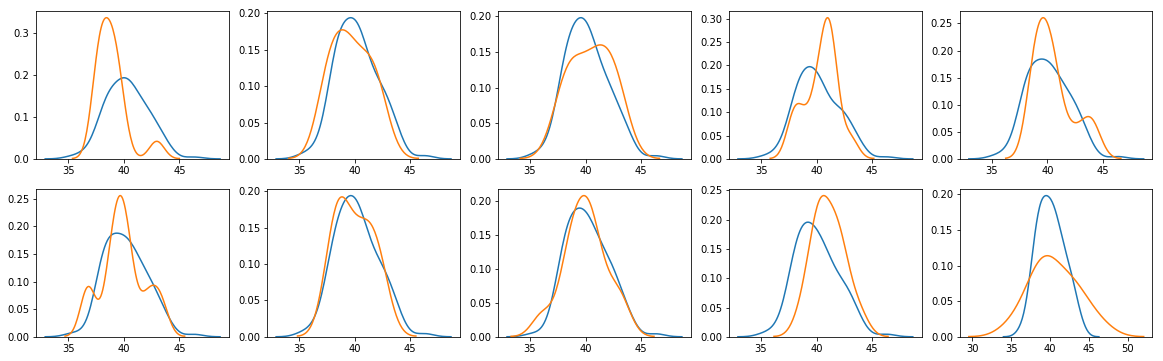

In [316]:
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(20, 6))

for ax, (tr_idx, val_idx) in zip(axs.flat, k10.split(X_train, y_train)):
    sns.kdeplot(y_train[tr_idx], ax=ax)
    sns.kdeplot(y_train[val_idx], ax=ax)

In [414]:
X_train = train.drop(columns='Yield')
y_train = train['Yield'].values
X_test = test.drop(columns='Yield')
y_test = test['Yield'].values

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((132, 46), (44, 46), (132,), (44,))

In [64]:
train.head()

,Yield,BiologicalMaterial01,BiologicalMaterial02,BiologicalMaterial03,BiologicalMaterial04,BiologicalMaterial05,BiologicalMaterial06,BiologicalMaterial08,BiologicalMaterial09,BiologicalMaterial10,...,ManufacturingProcess36,ManufacturingProcess37,ManufacturingProcess38,ManufacturingProcess39,ManufacturingProcess40,ManufacturingProcess41,ManufacturingProcess42,ManufacturingProcess43,ManufacturingProcess44,ManufacturingProcess45
143,40.54,6.25,54.57,67.56,12.10,17.66,47.80,17.32,12.89,2.73,...,0.020,1.0,3.0,7.2,0.0,0.0,11.7,0.5,1.8,2.3
3,42.03,8.01,60.97,67.48,14.65,19.36,53.14,19.04,12.55,3.46,...,0.018,0.7,2.0,7.2,0.0,0.0,12.0,1.0,1.8,2.3
101,37.30,5.85,51.75,64.02,10.41,20.40,44.30,16.96,12.68,2.34,...,0.020,1.6,2.0,7.2,0.0,0.0,11.5,0.8,1.9,2.3
123,42.58,6.03,52.58,65.05,11.45,19.11,46.06,17.23,12.84,2.67,...,0.019,0.9,2.0,7.1,0.1,0.2,11.5,0.5,1.9,2.2
154,37.51,6.25,52.68,65.12,11.64,18.11,45.42,17.51,13.01,2.88,...,0.020,0.7,3.0,7.3,0.1,0.1,10.7,0.7,1.8,2.1


In [103]:
def print_r2_rmse(y_true, y_pred):
    print("Baseline: r2:{:.4f}, rmse:{:.4f}".format(r2_score(y_true, y_pred), 
                                                np.sqrt(mean_squared_error(y_true, y_pred))))

In [415]:
# baseline: Mean
baseline_reg = DummyRegressor(strategy='mean')

baseline_reg.fit(X_train, y_train)
y_pred = baseline_reg.predict(X_test)
print_r2_rmse(y_test, y_pred)

Baseline: r2:-0.0089, rmse:1.7010


In [ ]:
# models:
# ------
# - Linear Regression
# - Ridge
# - ElasticNet
# - PLS
# - PCR

In [161]:
def remove_cols(X):
    to_keep = [0, 2, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 
               18, 19, 20, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32,
               33, 34, 35, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47,
               48, 49, 50, 52, 53, 54, 55]
    return X[:, to_keep]

In [190]:
preprocessing_transformer = make_pipeline(PowerTransformer(standardize=True), 
                                          SimpleImputer())

highcorr_transformer = FunctionTransformer(func=remove_cols)

In [144]:
corr = X_trans.corr()
to_remove = find_correlated_columns(corr, threshold=.85)

Given threshold=0.85, found 9 columns above the threshold


In [164]:
X_trans.head()

,BiologicalMaterial01,BiologicalMaterial03,BiologicalMaterial05,BiologicalMaterial08,BiologicalMaterial09,BiologicalMaterial10,BiologicalMaterial11,ManufacturingProcess01,ManufacturingProcess02,ManufacturingProcess03,...,ManufacturingProcess35,ManufacturingProcess36,ManufacturingProcess37,ManufacturingProcess38,ManufacturingProcess39,ManufacturingProcess40,ManufacturingProcess42,ManufacturingProcess43,ManufacturingProcess44,ManufacturingProcess45
0,-0.226262,-0.067610,-0.451134,-0.284542,0.006659,-0.106571,-0.277871,0.870369,0.568485,-8.827386e-02,...,1.317349,0.52576,0.006793,0.903199,0.230769,-0.411877,0.509319,-0.787042,-0.514994,0.665364
1,2.106653,-0.087971,0.496860,2.183148,-0.759359,1.183280,1.425750,-3.219141,-2.014114,-1.438702e-15,...,1.317349,-1.71730,-0.693896,-0.963694,0.230769,-0.411877,1.401177,0.311950,-0.514994,0.665364
2,-0.823117,-0.963248,1.040561,-0.830298,-0.473863,-0.903507,-0.765634,0.066850,0.586630,-5.519561e-01,...,-0.783233,0.52576,1.234600,-0.963694,0.230769,-0.411877,-0.015004,-0.090545,0.412087,0.665364
3,-0.550960,-0.703785,0.362252,-0.419969,-0.109953,-0.223485,-0.383929,-0.095759,0.532331,3.903075e-01,...,-0.519211,-0.59522,-0.219103,-0.963694,-0.145576,2.427908,-0.015004,-0.787042,0.412087,0.080951
4,-0.226262,-0.686117,-0.192491,-0.000812,0.292246,0.178001,-0.386097,1.165410,0.550385,3.021665e+00,...,0.566646,0.52576,-0.693896,0.903199,0.639042,2.427908,-1.644475,-0.308899,-0.514994,-0.421200


In [246]:
def plot_residual(y_true, y_pred, title=''):
    
    res = y_pred - y_true

    plt.figure(figsize=(12, 6))

    plt.subplot(121)
    plt.plot(y_true, y_pred, '.')
    plt.plot([36, 46], [36, 46], 'k--')
    plt.xlabel('y_true')
    plt.ylabel('y_pred')

    plt.subplot(122)
    plt.plot(y_pred, res, '.')
    plt.axhline(color='k', linestyle='--')
    plt.xlabel('y_pred')
    plt.ylabel('residuals')
    
    plt.gcf().suptitle(title)

Pretty printing has been turned OFF


In [416]:
# Linear Regression
lr_estimator = make_pipeline(SimpleImputer(), StandardScaler(), LinearRegression())

y_pred = cross_val_predict(lr_estimator, X_trans, y_train, cv=k10)

# cross-validation
print_r2_rmse(y_train, y_pred)

Baseline: r2:0.2458, rmse:1.6371


In [431]:
# pls
pls_estimator = make_pipeline(preprocessing_transformer, PLSRegression())
pls_params = {
    'plsregression__n_components': list(range(2, 15)),
}

pls_grid = GridSearchCV(pls_estimator, pls_params, scoring='r2', n_jobs=4,
                        cv=ss, return_train_score=False, verbose=1)

In [432]:
pls_grid.fit(X_train, y_train)

Fitting 25 folds for each of 13 candidates, totalling 325 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.4s
[Parallel(n_jobs=4)]: Done 325 out of 325 | elapsed:   21.9s finished


GridSearchCV(cv=ShuffleSplit(n_splits=25, random_state=123, test_size=0.25, train_size=None),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('pipeline', Pipeline(memory=None,
     steps=[('powertransformer', PowerTransformer(copy=True, method='yeo-johnson', standardize=True)), ('simpleimputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       verbose=0))])), ('plsregression', PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06))]),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'plsregression__n_components': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='r2', verbose=1)

In [433]:
pls_grid.best_score_, pls_grid.best_params_

(-26.85723697234497, {'plsregression__n_components': 3})

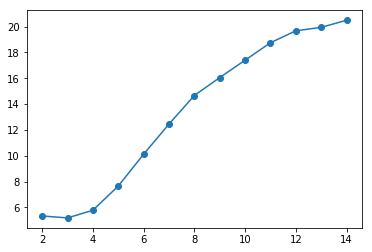

In [434]:
n_comp = pls_grid.cv_results_['param_plsregression__n_components'].astype(int)
val_score = np.sqrt(-pls_grid.cv_results_['mean_test_score'])

plt.plot(n_comp, val_score, 'o-')

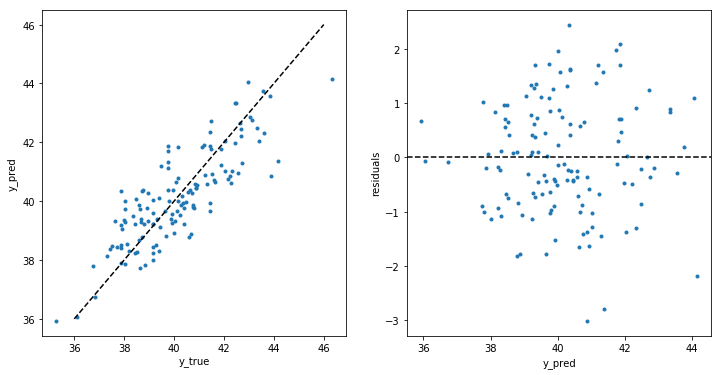

In [435]:
plot_residual(y_train, pls_grid.predict(X_train).ravel())

In [360]:
pls_results = pd.DataFrame(pls_grid.cv_results_)

In [361]:
pls_results.head()

,mean_fit_time,mean_score_time,mean_test_score,param_plsregression__n_components,params,rank_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,std_fit_time,std_score_time,std_test_score
0,0.416451,0.005422,-27.103663,2,{'plsregression__n_components': 2},2,-6.566508,0.629913,0.370428,-103.158062,-29.246158,0.010221,0.002143,39.153997
1,0.341500,0.005937,-20.521210,3,{'plsregression__n_components': 3},1,-2.366084,0.666711,0.457986,-36.380120,-68.941692,0.030137,0.002521,27.223371
2,0.295985,0.005398,-80.838789,4,{'plsregression__n_components': 4},3,-22.333915,0.611519,0.417276,-7.110710,-394.596275,0.022079,0.000940,151.903119
3,0.334559,0.005655,-167.781080,5,{'plsregression__n_components': 5},4,-56.839164,0.588924,0.338268,-3.094039,-817.697151,0.037372,0.002155,314.953122
4,0.332070,0.004439,-246.769077,6,{'plsregression__n_components': 6},5,-86.647799,0.614857,0.245950,-0.432427,-1202.874796,0.015398,0.000440,463.454592


In [370]:
pls_results['split1_test_score']

0     0.629913
1     0.666711
2     0.611519
3     0.588924
4     0.614857
5     0.556704
6     0.547736
7     0.503318
8     0.508862
9     0.514296
10    0.508560
11    0.507985
12    0.498650
Name: split1_test_score, dtype: float64

In [499]:
# pcr 
pcr_estimator = make_pipeline(preprocessing_transformer, 
                              PCA(), 
                              LinearRegression())

pcr_params = {
    'pca__n_components': list(range(2, 20))
}

pcr_grid = GridSearchCV(pcr_estimator, pcr_params, scoring='neg_mean_squared_error', n_jobs=4, 
                        return_train_score=True, verbose=1,cv=ss)

In [500]:
pcr_grid.fit(X_train, y_train)

Fitting 25 folds for each of 18 candidates, totalling 450 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   17.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   35.2s
[Parallel(n_jobs=4)]: Done 450 out of 450 | elapsed:   35.8s finished


GridSearchCV(cv=ShuffleSplit(n_splits=25, random_state=123, test_size=0.25, train_size=None),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('pipeline', Pipeline(memory=None,
     steps=[('powertransformer', PowerTransformer(copy=True, method='yeo-johnson', standardize=True)), ('simpleimputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       verbose=0))])), ('pca', PCA(copy=True, iterated_pow...ression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'pca__n_components': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=1)

In [501]:
np.sqrt(-pcr_grid.best_score_), pcr_grid.best_params_

(3.2211551085055747, {'pca__n_components': 3})

In [502]:
1 - pcr_grid.predict(X_train).var()/y_train.var()

0.5538304816072439

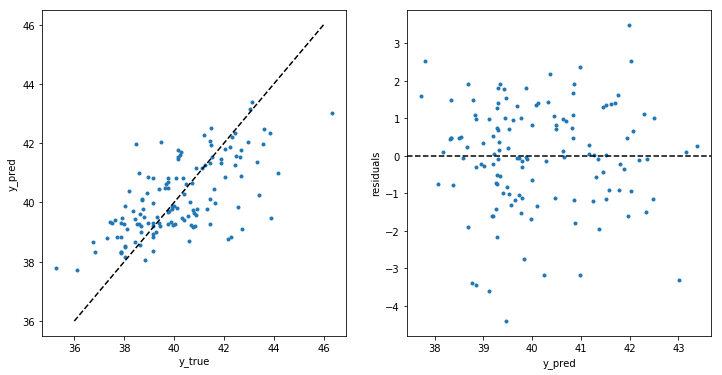

In [503]:
plot_residual(y_train, pcr_grid.predict(X_train))

In [517]:
# ridge 
ridge_estimator = make_pipeline(preprocessing_transformer, 
                                StandardScaler(), 
                                PCA(n_components=.95),
                                Ridge())

ridge_params = {
    'ridge__alpha': np.logspace(np.log10(.1), np.log10(10), base=10, num=10),
}

ridge_grid = GridSearchCV(ridge_estimator, ridge_params, scoring='neg_mean_squared_error', n_jobs=4, 
                          cv=ss, return_train_score=True, verbose=True)

In [518]:
ridge_grid.fit(X_train, y_train)

Fitting 25 folds for each of 10 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.5s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:   17.6s finished


GridSearchCV(cv=ShuffleSplit(n_splits=25, random_state=123, test_size=0.25, train_size=None),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('pipeline', Pipeline(memory=None,
     steps=[('powertransformer', PowerTransformer(copy=True, method='yeo-johnson', standardize=True)), ('simpleimputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       verbose=0))])), ('standardscaler', StandardScaler(c...it_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'ridge__alpha': array([ 0.1    ,  0.16681,  0.27826,  0.46416,  0.77426,  1.29155,
        2.15443,  3.59381,  5.99484, 10.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=True)

In [519]:
np.sqrt(-ridge_grid.best_score_), ridge_grid.best_params_

(6.366605054006211, {'ridge__alpha': 10.0})

In [520]:
1 - ridge_grid.predict(X_train).var()/y_train.var()

0.3335293655094522

In [460]:
ridge_result = pd.DataFrame(ridge_grid.cv_results_)
ridge_result.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_ridge__alpha,params,rank_test_score,split0_test_score,split0_train_score,split10_test_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.261013,0.005548,-684.382026,0.814128,0.01,{'ridge__alpha': 0.01},10,-41.356530,0.820231,-7039.767131,...,0.170863,0.808775,-1.594809,0.809955,0.404433,0.793847,0.021901,0.002497,1593.896183,0.021137
1,0.251885,0.005386,-674.910607,0.814113,0.0215443,{'ridge__alpha': 0.021544346900318832},9,-47.864863,0.820204,-6898.708074,...,0.171280,0.808773,-1.562662,0.809950,0.405142,0.793844,0.022423,0.001745,1568.230890,0.021138
2,0.276457,0.006246,-655.724729,0.814052,0.0464159,{'ridge__alpha': 0.046415888336127774},8,-61.716577,0.820098,-6601.639864,...,0.172132,0.808768,-1.498978,0.809928,0.406558,0.793833,0.025653,0.002371,1514.646337,0.021141
3,0.256251,0.006632,-619.298642,0.813840,0.1,{'ridge__alpha': 0.1},7,-89.626757,0.819736,-6009.204427,...,0.173804,0.808745,-1.381924,0.809838,0.409206,0.793788,0.025494,0.002587,1409.289793,0.021152
4,0.244595,0.005988,-557.666207,0.813218,0.215443,{'ridge__alpha': 0.21544346900318834},6,-137.809707,0.818750,-4969.338257,...,0.176961,0.808659,-1.189492,0.809499,0.413706,0.793629,0.018385,0.002072,1228.539817,0.021179


In [521]:
y_pred = ridge_grid.predict(X_train)

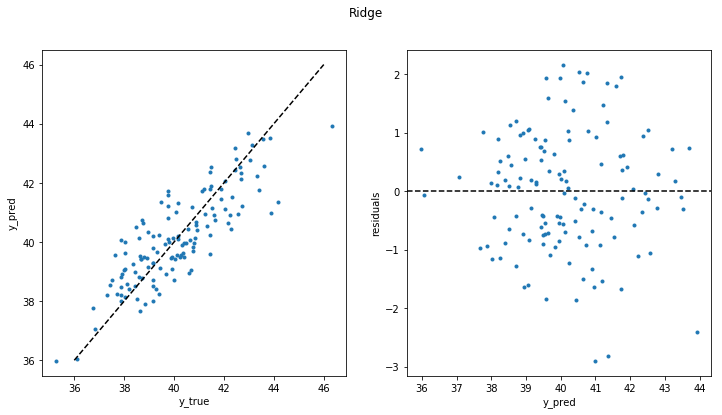

In [522]:
plot_residual(y_train, y_pred, 'Ridge')

In [523]:
# elasticnet
elastic_estimator = make_pipeline(preprocessing_transformer, 
                                  StandardScaler(), 
                                  ElasticNet())

elastic_params = {
    'elasticnet__alpha':np.logspace(np.log10(.01), np.log10(1), base=10, num=10),
    'elasticnet__l1_ratio':np.arange(.1, .91, .1),
}

elastic_grid = GridSearchCV(elastic_estimator, elastic_params, scoring='neg_mean_squared_error',
                            cv=ss, n_jobs=-1, return_train_score=True, verbose=True)

In [524]:
elastic_grid.fit(X_train, y_train)

Fitting 25 folds for each of 90 candidates, totalling 2250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2250 out of 2250 | elapsed:  2.0min finished


GridSearchCV(cv=ShuffleSplit(n_splits=25, random_state=123, test_size=0.25, train_size=None),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('pipeline', Pipeline(memory=None,
     steps=[('powertransformer', PowerTransformer(copy=True, method='yeo-johnson', standardize=True)), ('simpleimputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       verbose=0))])), ('standardscaler', StandardScaler(c...alse, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'elasticnet__alpha': array([0.01   , 0.01668, 0.02783, 0.04642, 0.07743, 0.12915, 0.21544,
       0.35938, 0.59948, 1.     ]), 'elasticnet__l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=True)

In [525]:
np.sqrt(-elastic_grid.best_score_), elastic_grid.best_params_

(1.2396883266977676, {'elasticnet__alpha': 0.21544346900318834, 'elasticnet__l1_ratio': 0.9})

In [526]:
# train r2
1 - elastic_grid.predict(X_train).var()/y_train.var()

0.6013240155893382

In [531]:
# test r2
1 - elastic_grid.predict(X_test).var()/y_test.var()

0.5971537085477794

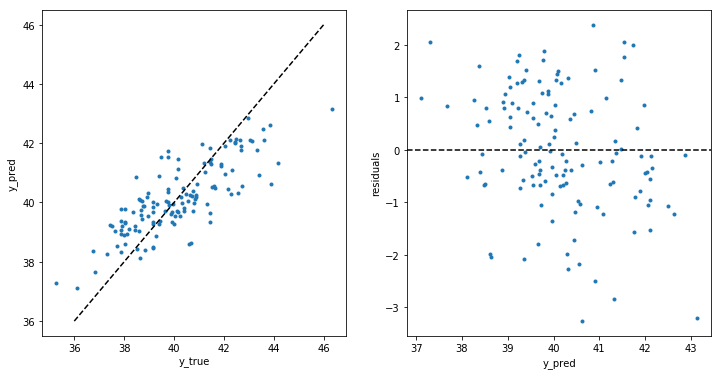

In [527]:
plot_residual(y_train, elastic_grid.predict(X_train))

In [528]:
elastic_reg = elastic_grid.best_estimator_.steps[2][1]

In [529]:
col_by_coefs = pd.Series(elastic_reg.coef_, index=X_train.columns.tolist()).abs().sort_values(ascending=False)

In [530]:
col_by_coefs.head(15)

ManufacturingProcess32    0.643416
ManufacturingProcess17    0.363628
ManufacturingProcess09    0.307420
ManufacturingProcess36    0.155791
BiologicalMaterial06      0.154295
ManufacturingProcess06    0.085396
ManufacturingProcess13    0.075400
ManufacturingProcess44    0.064651
ManufacturingProcess31    0.040213
ManufacturingProcess37    0.033515
ManufacturingProcess30    0.023359
ManufacturingProcess15    0.006715
BiologicalMaterial11      0.000000
ManufacturingProcess11    0.000000
ManufacturingProcess01    0.000000
dtype: float64

In [498]:
target_corr.abs().head(10)

ManufacturingProcess36    0.528420
ManufacturingProcess13    0.503680
ManufacturingProcess17    0.425807
ManufacturingProcess04    0.263550
ManufacturingProcess24    0.210200
ManufacturingProcess02    0.206276
ManufacturingProcess35    0.174233
ManufacturingProcess37    0.159314
ManufacturingProcess01    0.101343
ManufacturingProcess23    0.096880
Name: Yield, dtype: float64

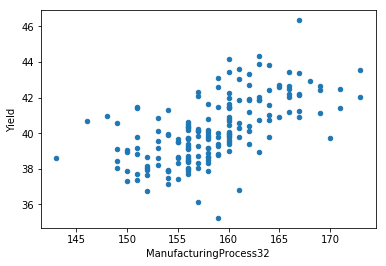

In [494]:
data.plot.scatter(x='ManufacturingProcess32', y='Yield')

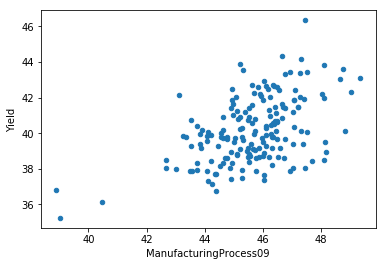

In [495]:
data.plot.scatter(x='ManufacturingProcess09', y='Yield')

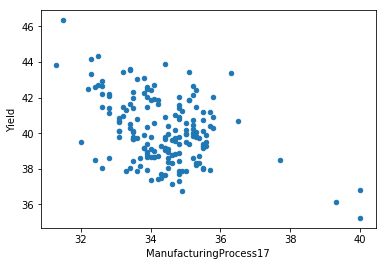

In [496]:
data.plot.scatter(x='ManufacturingProcess17', y='Yield')

In [377]:
X_reduce = pls_grid.transform(X_train)
X_reduce.shape

(132, 3)

In [378]:
scores = cross_val_score(LinearRegression(), X_reduce, y_train, scoring='r2', cv=k10)

In [380]:
scores.mean()

0.5438885246578826